In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from files.Simulation import Simulation
from files.Source import Source
from files.Observer import Observer
from files.Propagator import Propagator
from files.Observer import TimeEvolutionObserverLog
from plot.Trajectory import Trajectory
from plot.Statistics import Statistics

## Simulation setup

#### Simulation setup

In [2]:
dimensions = 3
sim = Simulation()

start simulation


#### Source 

In [3]:
nr_particles = 1*10**1
source_pos = np.array([1.0, 1.0, 1.0], dtype=np.float32)
delta_rho_div_phi = 1 #1/2**0.5 # (delta_r_rho / delta_r_phi)
gyro_radius = 10**11 # [m]; 1pc

source = Source(gyro_radius, source_pos, nr_particles, dimensions)
sim.add_source(source)

Source initialized


#### Propagator

In [4]:
nr_steps = 2*10**5
step_size = 0.5*10**10 # [m]
mfp = np.array([2.13*10**12/2.0, 2.13*10**12/2.0, 2.1078*10**12], dtype=np.float32)  # [m]

propagator = Propagator(nr_steps, step_size, mfp)
sim.add_propagator(propagator)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1mCannot resolve setattr: (instance.jitclass.Propagator#7fc20d88b340<isotropic:bool,nr_steps:int32,dimensions:int32,step_distance:float32,step_size:float32,gyro_radius_eff:float32,speed:float32,chi_isotropic:float32,prob:array(float32, 1d, A),pos:array(float32, 1d, A),direction:array(float32, 1d, A),phi:float32,distance:float32>).pitch_angle_const = Literal[bool](False)
[1m
File "files/Propagator.py", line 32:[0m
[1m    def __init__(self, nr_steps, step_size, mean_free_path):
        <source elided>
        self.dimensions = 3
[1m        self.pitch_angle_const = False
[0m        [1m^[0m[0m
[0m
[0m[1mDuring: typing of set attribute 'pitch_angle_const' at /home/patrick/Documents/rwpropa/files/Propagator.py (32)[0m
[1m
File "files/Propagator.py", line 32:[0m
[1m    def __init__(self, nr_steps, step_size, mean_free_path):
        <source elided>
        self.dimensions = 3
[1m        self.pitch_angle_const = False
[0m        [1m^[0m[0m

[0m[1mDuring: resolving callee type: jitclass.Propagator#7fc20d88b340<isotropic:bool,nr_steps:int32,dimensions:int32,step_distance:float32,step_size:float32,gyro_radius_eff:float32,speed:float32,chi_isotropic:float32,prob:array(float32, 1d, A),pos:array(float32, 1d, A),direction:array(float32, 1d, A),phi:float32,distance:float32>[0m
[0m[1mDuring: typing of call at <string> (3)
[0m
[0m[1mDuring: resolving callee type: jitclass.Propagator#7fc20d88b340<isotropic:bool,nr_steps:int32,dimensions:int32,step_distance:float32,step_size:float32,gyro_radius_eff:float32,speed:float32,chi_isotropic:float32,prob:array(float32, 1d, A),pos:array(float32, 1d, A),direction:array(float32, 1d, A),phi:float32,distance:float32>[0m
[0m[1mDuring: typing of call at <string> (3)
[0m
[1m
File "<string>", line 3:[0m
[1m<source missing, REPL/exec in use?>[0m


#### Observer

In [22]:
substeps = [False, False, True] # observe only steps (no substeps)
min_step = 1
max_step = nr_steps
nr_obs_steps = 200

observer = TimeEvolutionObserverLog(min_step, max_step, nr_obs_steps, substeps)
sim.add_observer(observer)

number steps:  169
Observer initialized


In [23]:
%time sim.run_simulation()
sim.save_data('data')

init source
CPU times: user 2min 20s, sys: 30.4 ms, total: 2min 20s
Wall time: 2min 20s


## Analyze statistics


init statistics plotting class


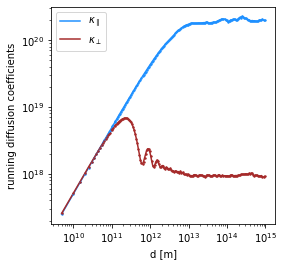

In [24]:
df = pd.read_pickle("data.pkl")
df_time_evolution_observer = df.loc[df['radius'] == -1.0]
dimensions = 3
sta = Statistics(df_time_evolution_observer, dimensions)
errors = False
df_kappas = sta.plot_diffusion_coefficients(errors)

In [25]:
rwp_d = df_kappas['d'].tolist()
rwp_kappa_perp = df_kappas['kappa_perp'].tolist()
rwp_kappa_para = df_kappas['kappa_para'].tolist()

In [26]:
### load crpropa data
crp_d = np.load('data/E_3e+16_bB_0.5_seeds_50_149_nr_20_d.npy')
crp_kappa_perp = np.load('data/E_3e+16_bB_0.5_seeds_50_149_nr_20_kappa_perp.npy')
crp_kappa_para = np.load('data/E_3e+16_bB_0.5_seeds_50_149_nr_20_kappa_para.npy')

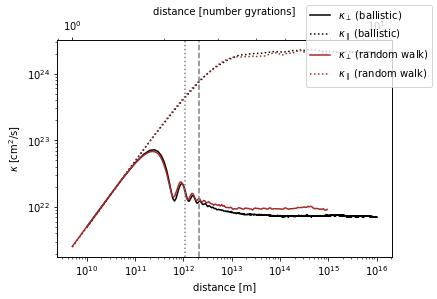

In [27]:
fig, ax1 = plt.subplots()

ax1.plot(crp_d, np.array(crp_kappa_perp)*10**4, label='$\kappa_\perp$ (ballistic)', color='k')
ax1.plot(crp_d, np.array(crp_kappa_para)*10**4, linestyle=':', label='$\kappa_\parallel$ (ballistic)', color='k')
ax1.plot(rwp_d, np.array(rwp_kappa_perp)*10**4, label='$\kappa_\perp$ (random walk)', color='brown')
ax1.plot(rwp_d, np.array(rwp_kappa_para)*10**4, linestyle=':', label='$\kappa_\parallel$ (random walk)', color='brown')

ax1.set_xlabel('distance [m]')
ax1.axvline(x=mfp[1], c='grey', ls=':')
ax1.axvline(x=mfp[2], c='grey', ls='--')
ax1.loglog()
ax1.set_ylabel('$\kappa$ [cm$^2$/s]')

ax2 = ax1.twiny()
#ax2.scatter(np.array([rwp_d[0], rwp_d[-1]]) / (2 * np.pi * gyro_radius), np.ones(2)*kappa_perp_mean*10**4, s=0.0001)
ax2.set_xlabel('distance [number gyrations]')
ax2.loglog()

fig.legend()
plt.show()
#plt.savefig('kappas_bB05.pdf')